## Demo: SingleRun with WeatherCriterion
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is **executed while a stop condition is not yet met**. In this case the elements of the sub processes have weather limitations. A separate 'significant wave height' criterion is defined for moving and for amount shifting. 

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd
import numpy as np

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugin

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

#### 1. Initialise simpy environment

In [2]:
# setup environment (simulation time needs to match the available weather data)
simulation_start  = datetime.datetime(2010, 1, 1, 0, 0)
my_env = simpy.Environment(initial_time=simulation_start.timestamp())

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,  # NB: LoadingFunction and UnloadingFunction are not mixed in
    ),
    {},
)

# create a TestMoveActivity object based on desired mixin classes
TestMoveActivity =  type(
    "TestMoveActivity",
    (
        plugin.HasWeatherPluginActivity,
        model.MoveActivity,  # the order is critical!
    ),
    {},
)

# create a TestShiftActivity object based on desired mixin classes
TestShiftActivity =  type(
    "TestShiftActivity",
    (
        plugin.HasWeatherPluginActivity,
        model.ShiftAmountActivity,  # the order is critical!
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 120,
                  "level": 120
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 120,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# generate a dataframe with weather data
metocean_df = pd.read_csv("../tests/data/unit_test_weather.csv")
metocean_df = metocean_df.set_index(pd.to_datetime(metocean_df["Time"], dayfirst=True))
metocean_df = metocean_df.sort_index()

metocean_df["Hs [m]"] = 4 + \
                        1.5*np.sin(metocean_df['  Hour']/24 * 8 *np.pi) + \
                        1.5*np.sin(metocean_df['  Hour']/24 * 6 *np.pi)

metocean_df = metocean_df.set_index(pd.to_datetime(metocean_df["Time"], dayfirst=True))
metocean_df = metocean_df.sort_index()
metocean_df["ts"] = metocean_df.index.values.astype(float) / 1_000_000_000

metocean_df.head()

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],ts
Time,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,1,01-01-2010 00:00,10,4.000000,1.262304e+09
2010-01-01 01:00:00,2010,1,1,1,2,01-01-2010 01:00,10,6.359698,1.262308e+09
2010-01-01 02:00:00,2010,1,1,2,3,01-01-2010 02:00,10,6.799038,1.262311e+09
2010-01-01 03:00:00,2010,1,1,3,4,01-01-2010 03:00,10,5.060660,1.262315e+09
2010-01-01 04:00:00,2010,1,1,4,5,01-01-2010 04:00,10,2.700962,1.262318e+09


In [7]:
# generate a weather criterion for the sailing process
sailing_crit = plugin.WeatherCriterion(
    name="sailing_crit",
    condition="Hs [m]",
    maximum=6,
    window_length=3600,
)

# generate a weather criterion for the loading process
loading_crit = plugin.WeatherCriterion(
    name="loading_crit",
    condition="Hs [m]",
    maximum=4.5,
    window_length=3600,
)

In [8]:
# initialise registry
registry = {}

In [9]:
# create a list of the sub processes
sub_processes = [
    TestMoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
        metocean_criteria=sailing_crit,
        metocean_df=metocean_df,
    ),
    TestShiftActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=3600,
        metocean_criteria=loading_crit,
        metocean_df=metocean_df,
    ),
    TestMoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
        metocean_criteria=sailing_crit,
        metocean_df=metocean_df,
    ),
    TestShiftActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=3600,
        metocean_criteria=loading_crit,
        metocean_df=metocean_df,
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [10]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [11]:
plot.get_log_dataframe(while_activity, [while_activity, sequential_activity, *sub_processes]).head()

,Activity,Timestamp,ActivityState,type,ref
0,while_sequential_activity_subcycle,2009-12-31 23:00:00.000000,START,NaN,NaN
1,while_sequential_activity_subcycle,2009-12-31 23:00:00.000000,START,subprocess,fd66057f-bce6-4d4a-940f-e253572d9226
2,while_sequential_activity_subcycle,2010-01-01 06:15:42.824591,STOP,subprocess,fd66057f-bce6-4d4a-940f-e253572d9226
3,while_sequential_activity_subcycle,2010-01-01 06:15:42.824591,START,subprocess,fd66057f-bce6-4d4a-940f-e253572d9226
4,while_sequential_activity_subcycle,2010-01-01 11:00:00.000000,STOP,subprocess,fd66057f-bce6-4d4a-940f-e253572d9226


In [12]:
plot.get_log_dataframe(sub_processes[0], [while_activity, sequential_activity, *sub_processes]).head()

,Activity,Timestamp,ActivityState,type,ref
0,sailing empty,2009-12-31 23:00:00.000000,WAIT_START,plugin,waiting on weather
1,sailing empty,2010-01-01 03:00:00.000000,WAIT_STOP,plugin,waiting on weather
2,sailing empty,2010-01-01 03:00:00.000000,START,NaN,NaN
3,sailing empty,2010-01-01 03:00:00.000000,STOP,NaN,NaN
4,sailing empty,2010-01-01 06:15:42.824591,START,NaN,NaN


##### 5.2 Visualise gantt charts

In [13]:
id_map = {act.id: act.name for act in [while_activity, sequential_activity, *sub_processes]}

In [14]:
res = plot.get_gantt_chart([vessel01], y_scale="numbers", static=True,id_map=id_map)
data = res['data']
layout = res['layout']

data.append({
    "name": "sailing_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[sailing_crit.maximum,sailing_crit.maximum],
})

data.append({
    "name": "Weather",
    "x":metocean_df.index,
    "y":metocean_df[sailing_crit.condition],
})

data.append({
    "name": "loading_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[loading_crit.maximum,loading_crit.maximum],
})

go.Figure(data=data, layout=layout)

**_Some observations:_**
* The moving criterion states that sailing can only commence when Hs is below 6 m, and there is a window of at least 3600 seconds. While the first data point from the metocean file has a Hs below 6 m, viz. 4 m, the next data point has a Hs higher than 6 m. Since the time interval is exactly 3600 seconds the vessel decides to wait. The first data point with a Hs lower than 6 m is found at 03:00 hours. The vessel then starts 'sailing empty'. However, since the vessels origin is 'to_site', 'sailing empty' takes 0 seconds. 
* The vessel is ready to start loading at 03:00 hours. However, the loading criterion states that loading can only commence when Hs is below 4.5 m. The first time this happens in the metocean dataseries is 04:00 o'clock. So the loading commences at 04:00 hours. 

In [15]:
plot.get_gantt_chart(sub_processes)

##### 5.3 Visualise container volume developments

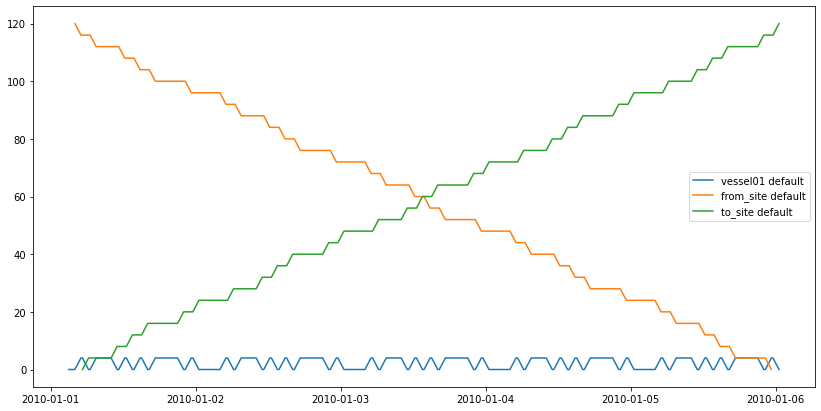

In [16]:
fig = plot.get_step_chart([vessel01, from_site, to_site])